In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# Beta Bernoulli Bandit
In this notebook, we implement Thompson Sampling for the Beta Bernoulli bandit problem. The reference is chapter 3 of 
___Russo, Daniel J., et al. "A tutorial on thompson sampling." Foundations and Trends® in Machine Learning 11.1 (2018): 1-96.__

In [2]:
class Environment:
    """
    The Environment/reward process follows a Bernoulli probability model.
    """
    def __init__(self, p_reward):
        self.p_reward = p_reward
        
    def reward(self, input_action):
        # Bernoulli reward model
        tmp = np.random.rand()
        if tmp <= self.p_reward[input_action]:
            output_reward = 1
        else:
            output_reward = 0
        return output_reward

In [3]:
class Agent:
    def __init__(self, alpha_init, beta_init, strategy):
        """
        The Agent maintains an internal model of the Environment/reward process 
        which is updated based on a history of interaction. Here the model is of the conjugate Bayes form with:
        
        Prior on reward probabilities: Beta(alpha,beta)
        Likelihood of reward: Bernoulli
        Posterior: Beta(alpha',beta')
        """
        self.alpha_init = alpha_init
        self.beta_init = beta_init
        
        self.alpha = alpha_init
        self.beta = beta_init
        
        self.strategy = strategy
        
    def action(self):
        action = 0
        if self.strategy.lower() == 'greedy': #greedy action
            expected_reward_probability = self.alpha / (self.alpha + self.beta)
            #action = np.argmax(expected_reward_probability)
            #include random tie breaking
            action = np.random.choice(np.flatnonzero(expected_reward_probability == expected_reward_probability.max()))
            
        elif self.strategy.lower() == 'ts':
            sampled_reward_probability = np.random.beta(self.alpha, self.beta, 3)
            #action = np.argmax(sampled_reward_probability)
            #include random tie breaking
            action = np.random.choice(np.flatnonzero(sampled_reward_probability == sampled_reward_probability.max()))

        return action
        
    def update(self, input_action, output_reward):
        self.alpha[input_action] = self.alpha[input_action] + output_reward 
        self.beta[input_action] = self.beta[input_action] + 1 - output_reward 
    
    def reset(self):
        self.alpha = self.alpha_init.copy()
        self.beta = self.beta_init.copy()
        
        
    

Next, we implement the three-armed beta Bernoulli bandit example from the above reference. 

In [4]:
# initialize environment
num_actions = 3
true_reward_probs = [0.9, 0.8, 0.7]
env = Environment(true_reward_probs)

In [5]:
# simulate the Thompson Sampling agent
nsim = 10000 # number of simulations / trials
T = 1000  # duration of each simulation

#for each action: uniform prior on the mean reward probability
alpha0 = np.ones((num_actions,))
beta0 = np.ones((num_actions,))
ts_agent = Agent(alpha0, beta0,'TS')

ts_action_count = np.zeros((T, num_actions))

for n in tqdm(range(nsim)):
    ts_agent.reset()
    
    for t in range(T):
        act = ts_agent.action()
        ts_action_count[t,act] = ts_action_count[t,act]+1 
        rwd = env.reward(act)
        ts_agent.update(act,rwd)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:46<00:00, 28.83it/s]


In [6]:
# simulate the greedy agent
#for each action: uniform prior on the mean reward probability
alpha0 = np.ones((num_actions,))
beta0 = np.ones((num_actions,))
greedy_agent = Agent(alpha0, beta0,'greedy')

greedy_action_count = np.zeros((T, num_actions))

for n in tqdm(range(nsim)):
    greedy_agent.reset()
    
    for t in range(T):
        act = greedy_agent.action()
        greedy_action_count[t,act] = greedy_action_count[t,act]+1 
        rwd = env.reward(act)
        greedy_agent.update(act,rwd)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:32<00:00, 47.16it/s]


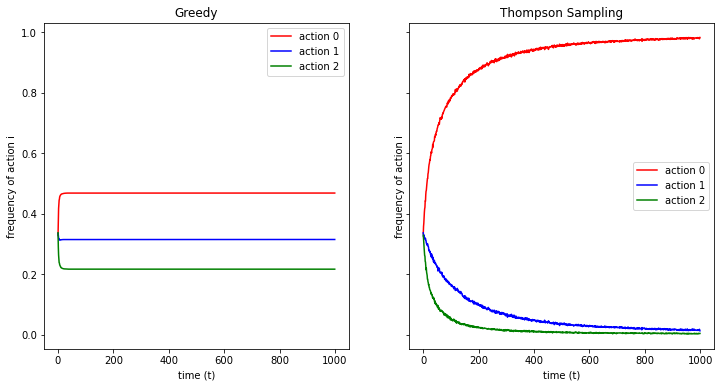

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharey = True)
colors = ['r','b','g']

for i in range(num_actions): 
    axs[0].plot(range(T),greedy_action_count[:,i]/nsim, c=colors[i], label='action '+str(i))
axs[0].set_title('Greedy')
axs[0].set_xlabel('time (t)')
axs[0].set_ylabel('frequency of action i')
axs[0].legend()

for i in range(num_actions): 
    axs[1].plot(range(T),ts_action_count[:,i]/nsim, c=colors[i], label='action '+str(i))
axs[1].set_title('Thompson Sampling')
axs[1].set_xlabel('time (t)')
axs[1].set_ylabel('frequency of action i')
axs[1].legend()

plt.show()

The agent employing Thompson Sampling outperforms the greedy agent and consistently selects the true optimal action more frequently as time passes. The benefits of exploration are evident, and Thompson Sampling provides one strategy for accomplishing this.